In [36]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())
import os
import numpy as np

from model import input, output, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS
from helpers_functions import evaluate

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Random seed
np.random.seed = 42

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Notes to self:
- Play with the padding, the kernel initializer and the normalization of images

In [37]:
# set the model
model = tf.keras.Model(inputs=[input], outputs=[output])
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

## Dataset

In [38]:
dataset_path = '../dataset/stage1_train'
ids = os.listdir(dataset_path)

In [39]:
X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [40]:
for n, id in tqdm(enumerate(ids), total=len(ids)):
  path = f"{dataset_path}/{id}"
  img = cv2.imread(f"{path}/images/{id}.png")

  img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  X[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

  for mask_file in os.listdir(path + "/masks/"):
    mask_ = cv2.imread(path + "/masks/" + mask_file, cv2.IMREAD_GRAYSCALE)
    mask_ = np.expand_dims(
      cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)),
      axis=-1
      )
    mask = np.maximum(mask, mask_)
  y[n] = mask

100%|██████████| 670/670 [00:27<00:00, 24.75it/s]


In [41]:
# Split data into train and test
random_elements = np.random.choice(len(X), int(len(X) * 0.8), replace=False)

mask = np.zeros(len(X), dtype=bool)
mask[random_elements] = 1

X_train = X[mask]
X_test = X[~mask]
y_train = y[mask]
y_test = y[~mask]


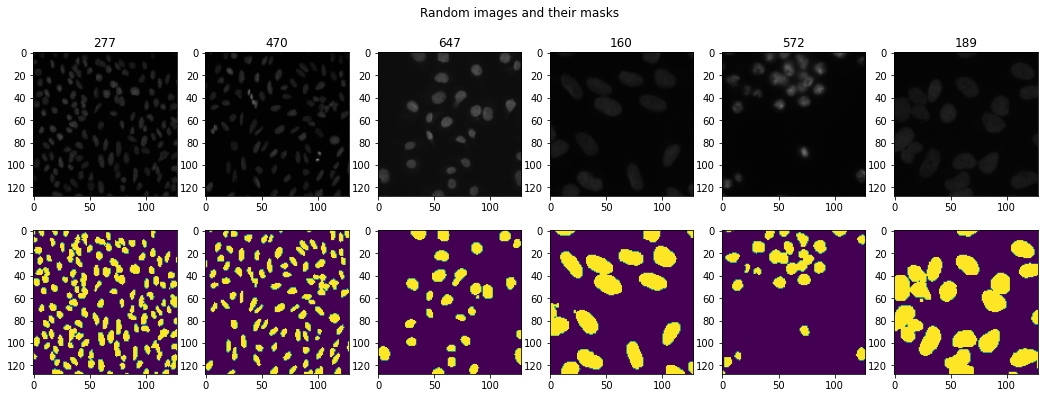

In [42]:
nb_images = 6
fig, (top, bottom) = plt.subplots(2, nb_images, figsize=(3 * nb_images, 6))
random_ids = np.random.rand(nb_images) * len(X)

fig.suptitle("Random images and their masks")

for i, (ax_t, ax_b) in enumerate(zip(top, bottom)):
  id = int(random_ids[i])
  ax_t.set_title(id)
  ax_t.imshow(X[id])
  ax_b.imshow(y[id])


## Callbacks

In [43]:
# EarlyStopping, ModelCheckpoint and Tensorboard
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_nuclei.h5', verbose=1, save_best_only=True) #save_weight_only ?
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [44]:
model.load_weights('./unet_nuclei.h5')
raise Exception("loaded previous model")

Exception: loaded previous model

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=25, callbacks=[model_checkpoint, early_stopping, tensorboard])

Epoch 1/25
16/16 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9613
Epoch 1: val_loss improved from inf to 0.08731, saving model to unet_nuclei.h5
16/16 [==============================] - 31s 2s/step - loss: 0.1006 - accuracy: 0.9613 - val_loss: 0.0873 - val_accuracy: 0.9673
Epoch 2/25
16/16 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9633
Epoch 2: val_loss did not improve from 0.08731
16/16 [==============================] - 27s 2s/step - loss: 0.0943 - accuracy: 0.9633 - val_loss: 0.1369 - val_accuracy: 0.9391
Epoch 3/25
16/16 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9586
Epoch 3: val_loss improved from 0.08731 to 0.08525, saving model to unet_nuclei.h5
16/16 [==============================] - 34s 2s/step - loss: 0.1070 - accuracy: 0.9586 - val_loss: 0.0853 - val_accuracy: 0.9672
Epoch 4/25
16/16 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9658
Epoch 4: val_loss improved f

## Make predictions, display a sample and evaluate

### Predict and visualize

In [50]:
y_pred = model.predict(X_test)
filtered_preds = (y_pred > 0.5).astype(np.uint8)

5/5 [==============================] - 2s 314ms/step


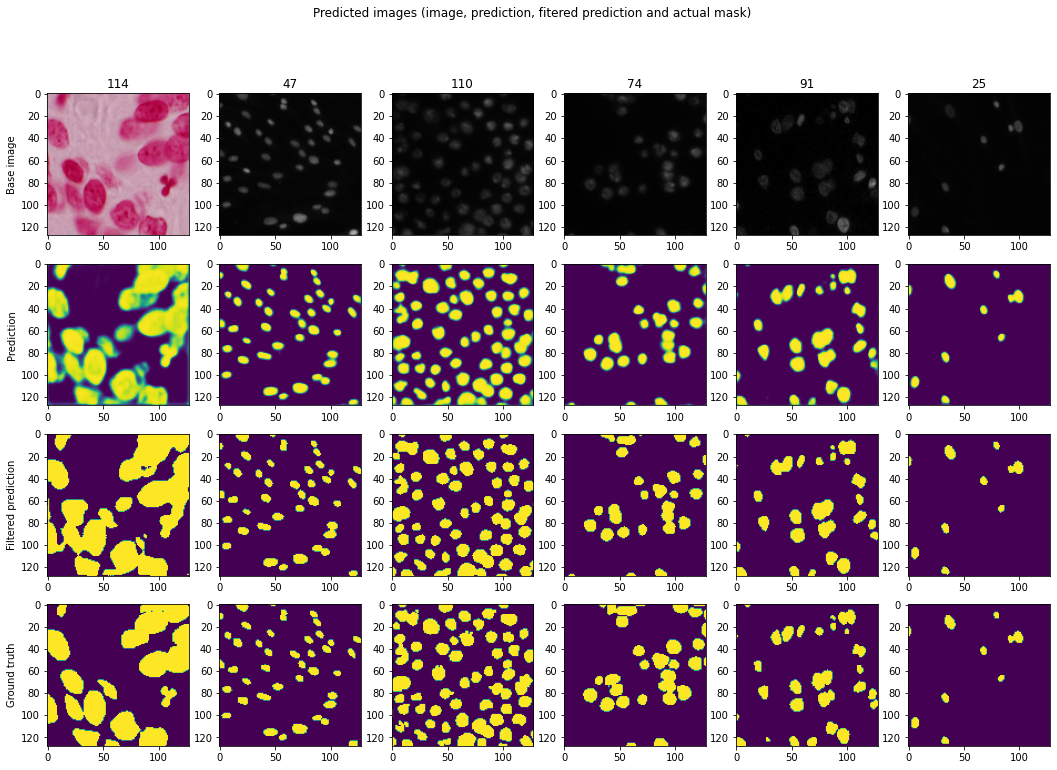

In [ ]:
nb_images = 6
fig, ax = plt.subplots(4, nb_images, figsize=(3 * nb_images, 12))
random_ids = np.random.rand(nb_images) * len(y_pred)

fig.suptitle("Predicted images (image, prediction, fitered prediction and actual mask)")

for i, (ax_x, ax_pred, ax_pred_filtered, ax_val) in enumerate(zip(*ax)):
  id = int(random_ids[i])
  ax_x.set_title(id)

  ax_x.imshow(X_test[id])
  ax_pred.imshow(y_pred[id])
  ax_pred_filtered.imshow(filtered_preds[id])
  ax_val.imshow(y_test[id])

  if not i:
    ax_x.set_ylabel("Base image")
    ax_pred.set_ylabel("Prediction")
    ax_pred_filtered.set_ylabel("Filtered prediction")
    ax_val.set_ylabel("Ground truth")

## Evaluate and tensorboard

In [62]:
evaluate(y_test, filtered_preds)

IoU        : 81.39
Dice Score : 44.87


In [ ]:
!tensorboard --logdir=logs/ --host localhost --port 8080

No supported GPU was found.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.9.1 at http://localhost:8080/ (Press CTRL+C to quit)
^C
